### Import library

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import cv2

In [40]:
print(os.listdir("./data"))

['training_fake', 'training_real']


In [22]:
real = "./data/training_real"
fake = "./data/training_fake"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

### Data Visualization

In [5]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

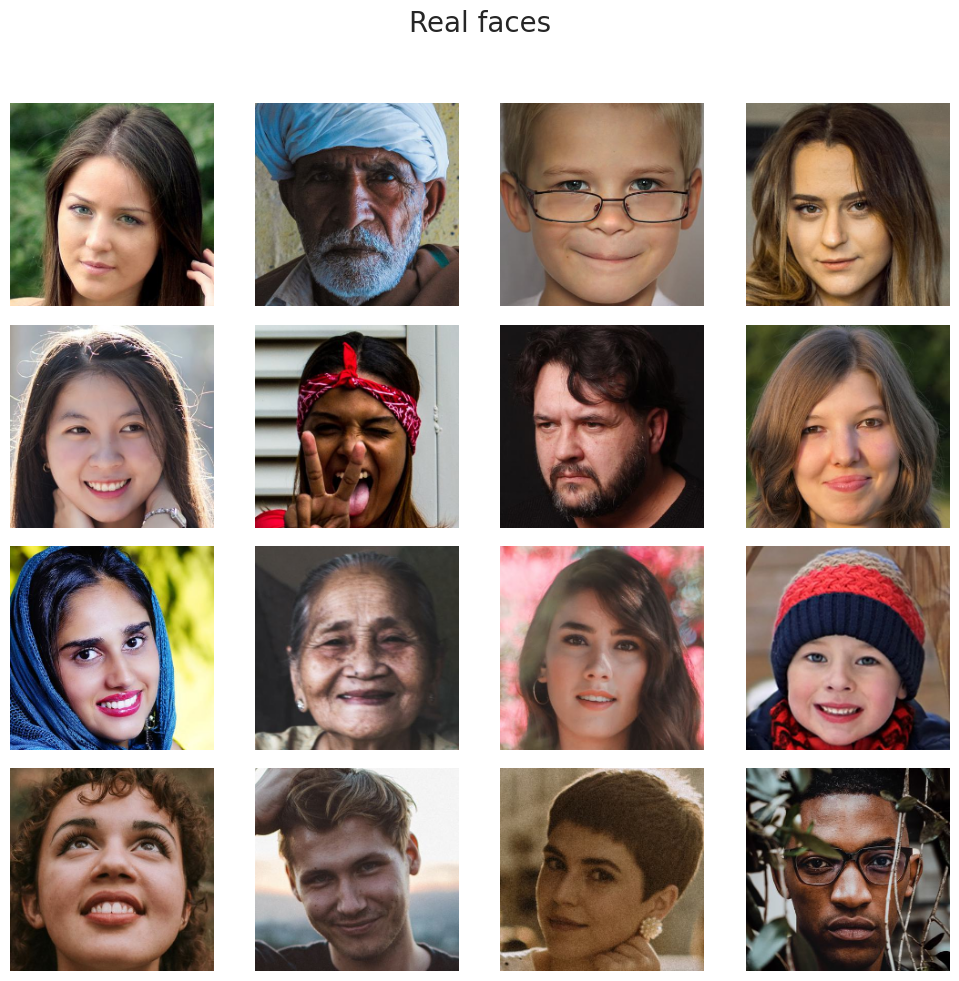

In [11]:
fig = plt.figure(figsize=(10, 10), dpi=100)
sns.set(style="white")

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

# Adjust layout to prevent overlapping of subplot titles and ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

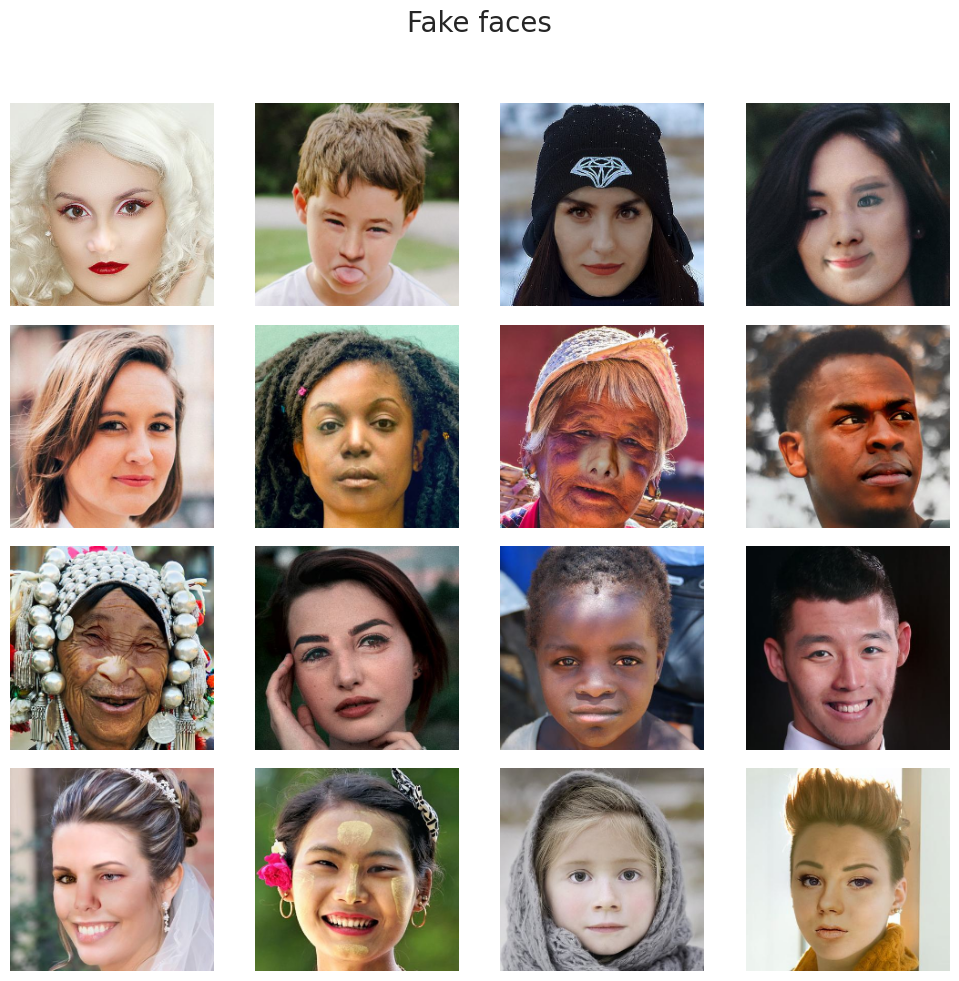

In [8]:
fig = plt.figure(figsize=(10, 10), dpi=100)
sns.set(style="white")

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.axis('off')

# Adjust layout to prevent overlapping of subplot titles and ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Data Augumentation

##### Define transformations



In [25]:
# Define transformations, make sure the normalization is matched with the pre-trained model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#### Split data into training and test

In [41]:
dataset_path = "./data"

# Load the dataset and apply the transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split into train and test sets with a ratio of 4:1
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model building

In [15]:
# Define Customer MobileNetV2
class CustomerMobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        # Replace the classifier with a new one for our face dataset
        self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [39]:
def calculate_loss_accuracy(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Inference mode, gradient is not needed
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)  # Multiply by batch size for total loss

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    final_loss = running_loss / total_predictions
    final_accuracy = correct_predictions / total_predictions
    return final_loss, final_accuracy

### Training

In [43]:
def fit(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Initialize lists to keep track of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train_predictions += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

        # Calculate and store training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train_predictions / total_train_predictions
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = calculate_loss_accuracy(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

    # Return the metrics
    return train_losses, train_accuracies, val_losses, val_accuracies

In [54]:
# Plot loss and accuracy
def plot_loss_accuracy(train_loss, train_accuracy, val_loss, val_accuracy):
    epochs = range(len(train_loss))
    plt.figure(figsize=(10, 5), dpi=100)

    # Convert accuracies to percentages
    train_accuracy = [accuracy * 100 for accuracy in train_accuracy]
    val_accuracy = [accuracy * 100 for accuracy in val_accuracies]

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [44]:
# Instantiate the model
model = CustomerMobileNetV2(num_classes=2)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the fit function and get the accuracy list for plotting
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    num_epochs=50,
    device=device
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [5/50]
Training Loss: 0.2733, Training Accuracy: 0.88
Validation Loss: 1.0406, Validation Accuracy: 0.67
Epoch [10/50]
Training Loss: 0.1638, Training Accuracy: 0.93
Validation Loss: 0.8531, Validation Accuracy: 0.68
Epoch [15/50]
Training Loss: 0.0885, Training Accuracy: 0.97
Validation Loss: 1.3290, Validation Accuracy: 0.68
Epoch [20/50]
Training Loss: 0.0317, Training Accuracy: 0.99
Validation Loss: 1.6772, Validation Accuracy: 0.64
Epoch [25/50]
Training Loss: 0.0232, Training Accuracy: 0.99
Validation Loss: 1.9268, Validation Accuracy: 0.62
Epoch [30/50]
Training Loss: 0.0384, Training Accuracy: 0.99
Validation Loss: 1.3341, Validation Accuracy: 0.70
Epoch [35/50]
Training Loss: 0.0197, Training Accuracy: 0.99
Validation Loss: 2.1553, Validation Accuracy: 0.64
Epoch [40/50]
Training Loss: 0.0325, Training Accuracy: 0.99
Validation Loss: 1.5709, Validation Accuracy: 0.69
Epoch [45/50]
Training Loss: 0.0435, Training Accuracy: 0.98
Validation Loss: 2.4325, Validation Accuracy

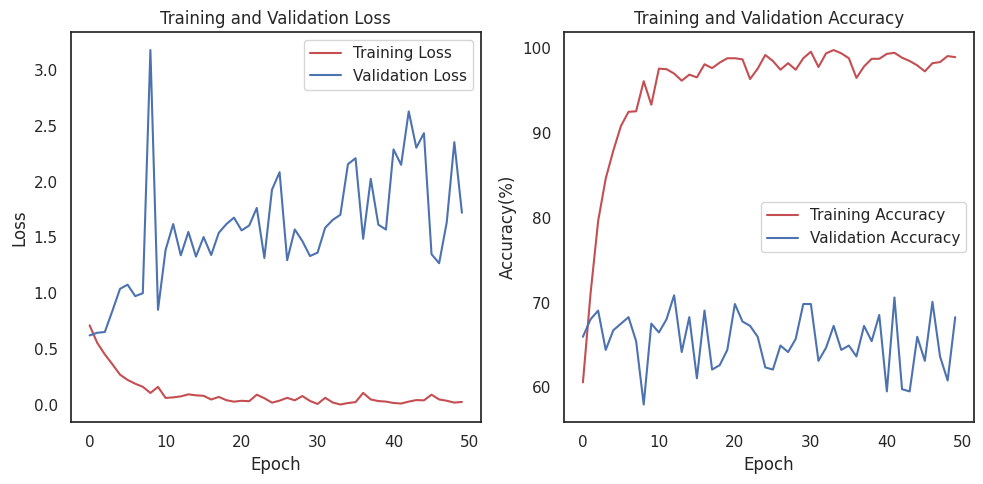

In [55]:
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)